In [82]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import shap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier
RC = RidgeClassifier()
from yellowbrick.classifier import ROCAUC
from pandas import read_csv
from sklearn.utils import resample
from matplotlib import pyplot
import numpy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\s_sad\Final Project\twitter_sentiment2.csv")

In [3]:
df.isnull().sum()

tweet              28
date                0
brand               0
sentiment_score     0
sentiment           0
dtype: int64

In [4]:
df =df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41714 entries, 0 to 41741
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet            41714 non-null  object 
 1   date             41714 non-null  object 
 2   brand            41714 non-null  object 
 3   sentiment_score  41714 non-null  float64
 4   sentiment        41714 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


In [6]:
df['sentiment'] = [0 if b=='Negative' else 1 if b== 'Neutral' else 2 for b in df.sentiment]
df['sentiment'].value_counts()

2    19106
1    12016
0    10592
Name: sentiment, dtype: int64

### Train, Test, Validation Split 

In [7]:
def train_test_validation(dataset):
    X = dataset.drop('sentiment', axis=1)
    y = dataset['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    train = pd.concat([X_train,y_train], axis=1)
    validation = pd.concat([X_validation, y_validation], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    return train, test, validation

In [8]:
train, test, validation = train_test_validation(df)
train

,tweet,date,brand,sentiment_score,sentiment
27956,utah marco bumpy case ahve touch tsla deliver ...,2022-12-01,tesla,0.4939,2
7779,gilbe pure garbage know sw also black rasta wo...,2022-10-18,bmw,-0.5267,0
8430,edmunds compare genesis gv tesla model ctinsid...,2022-10-19,tesla,0.0000,1
5829,one many characteristic set human apart primat...,2022-10-14,tesla,0.3818,2
24185,tesla share rise citi upgrade elon musk talk n...,2022-11-23,tesla,0.2960,2
...,...,...,...,...,...
14393,sofi different amazon year tesla year ago dont...,2022-11-02,tesla,0.1779,2
29033,would awesome do work,2022-12-03,tesla,0.6249,2
15273,doge exactly attitude towards interference,2022-11-04,tesla,0.0000,1
40034,people think tesla stock muchbut still able se...,2022-12-28,tesla,0.2960,2


In [13]:
vectorizer = TfidfVectorizer(min_df = 10)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
vectorizer.get_feature_names_out()

array(['aapl', 'ab', 'abandon', ..., 'zero', 'zone', 'zoom'], dtype=object)

In [14]:
y_test.value_counts()

2    6261
1    3975
0    3530
Name: sentiment, dtype: int64

In [17]:
X_train.shape

(20961, 2985)

In [18]:
X_test.shape

(13766, 2985)

In [19]:
kfold = StratifiedKFold(n_splits=10)

### Hyperparameter Tuning on Validation dataset 

In [21]:
X_val = validation["tweet"]
y_val = validation["sentiment"]
X_val = vectorizer.transform(X_val)

In [22]:
X_val.shape

(6987, 2985)

In [23]:
lgb = LGBMClassifier(class_weight='balanced', learning_rate=0.01, n_estimators=50,num_leaves=20, objective='multiclass',
                                          num_classes = 3)
xgb = XGBClassifier(colsample_bytree = 0.3, reg_alpha = 0, reg_lambda = 0, objective= 'multi:softmax')
svc = SVC(C = 10, gamma = 0.1, kernel = 'rbf', probability=True)
mlp = MLPClassifier(activation = 'relu', alpha = 0.05, hidden_layer_sizes = (100,), learning_rate = 'adaptive', solver= 'adam')
lr = LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')

clfs = {
   "LightGBM": lgb,
    "XGBoost": xgb,
    "Support Vector Machine":svc,
    "Multilayer Perceptron":mlp,
    "Logistic Regression": lr
}

    

train_score = []
val_score = []
F1_Macro = []
Precision = []
Recall = []
Fbeta_half = []
cv_results = []


for name,clf in tqdm(clfs.items()):
    clf.fit(X_train, y_train)
    y_predict_train = clf.predict(X_train)
    y_predict_test = clf.predict(X_val)
    train_score.append(accuracy_score(y_train, y_predict_train))
    val_score.append(accuracy_score(y_val, y_predict_test))
    F1_Macro.append(f1_score(y_val,y_predict_test, average = 'macro'))
    Precision.append(precision_score(y_val,y_predict_test, average = 'macro'))    
    Recall.append(recall_score(y_val,y_predict_test, average = 'macro'))
    Fbeta_half.append(fbeta_score(y_val,y_predict_test, beta = 0.5, average = "macro"))
    cv_results.append(np.mean(cross_val_score(clf,X_train,y_train, scoring = "accuracy", cv = 10, n_jobs =4)))

  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
models_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Training":train_score,
                         "Accuracy Validation": val_score, "F1 Macro": F1_Macro, "Precision": Precision,
                         "Recall": Recall, "Fbeta_half": Fbeta_half, "Cross Validation": cv_results}).sort_values('F1 Macro',ascending=False)
models_df

,Models,Accuracy Training,Accuracy Validation,F1 Macro,Precision,Recall,Fbeta_half,Cross Validation
2,Support Vector Machine,0.926769,0.862173,0.850454,0.853587,0.852009,0.851766,0.855350
4,Logistic Regression,0.921092,0.858738,0.847487,0.851173,0.847326,0.849261,0.850341
3,Multilayer Perceptron,0.996517,0.857593,0.846504,0.850057,0.844842,0.848397,0.852106
1,XGBoost,0.863031,0.800343,0.778622,0.805509,0.779420,0.790693,0.795716
0,LightGBM,0.632174,0.621297,0.608123,0.631136,0.637004,0.615244,0.624969


### Details Summary of results with, without hyperparameter and SMOTE 

In [25]:
def model_inplace(model, X_train, X_val,y_train, y_val):
    #X_train = scaler.fit_transform(X_train)
    #X_val = scaler.transform(X_test)
    model.fit(X_train,y_train)
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    class_names = ['negative','neutral','positive']
    target_names = ['negative', 'neutral', 'positive']
    print("score on train set:", accuracy_score(y_train, train_predictions))
    print("score on test set:", accuracy_score(y_val,val_predictions))
    print(classification_report(y_train, train_predictions, target_names=target_names))
    print(classification_report(y_val,val_predictions, target_names=target_names))
    visualizer = ROCAUC(model, classes=["negative", "neutral", "positive"])
    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_val, y_val)        # Evaluate the model on the test data
    print(visualizer.show())
    print(plot_confusion_matrix(model, X_val, y_val, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical'))

In [26]:
# Simple Models
mlp_s = MLPClassifier()
svc_s = SVC(class_weight = 'balanced')
xgboost_s = XGBClassifier(objective= 'multi:softmax')
lgbmc_s = LGBMClassifier(objective='multiclass',num_classes = 3)
lr_s =LogisticRegression(class_weight = 'balanced')

In [27]:
# Models with hyperparameters
mlp = MLPClassifier(activation = 'relu', alpha = 0.05, hidden_layer_sizes = (100,), learning_rate = 'adaptive', solver= 'adam')
svc = SVC(C = 10, gamma = 0.1, kernel = 'rbf', probability=True) #class_weight = 'balanced')
xgboost = XGBClassifier(colsample_bytree = 0.3, reg_alpha = 0, reg_lambda = 0, objective= 'multi:softmax')
lgbmc = LGBMClassifier(class_weight='balanced', learning_rate=0.01, n_estimators=50,num_leaves=20, objective='multiclass',
                                          num_classes = 3)
lr =LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')

# Simple Models

score on train set: 0.9988073088116025
score on test set: 0.8437097466723916
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      5352
     neutral       1.00      1.00      1.00      6018
    positive       1.00      1.00      1.00      9591

    accuracy                           1.00     20961
   macro avg       1.00      1.00      1.00     20961
weighted avg       1.00      1.00      1.00     20961

              precision    recall  f1-score   support

    negative       0.78      0.72      0.75      1710
     neutral       0.85      0.90      0.88      2023
    positive       0.87      0.87      0.87      3254

    accuracy                           0.84      6987
   macro avg       0.83      0.83      0.83      6987
weighted avg       0.84      0.84      0.84      6987



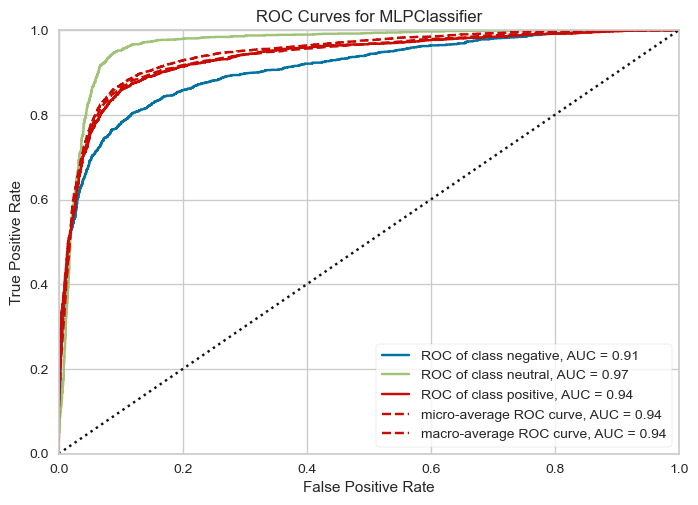

AxesSubplot(0.125,0.11;0.775x0.77)


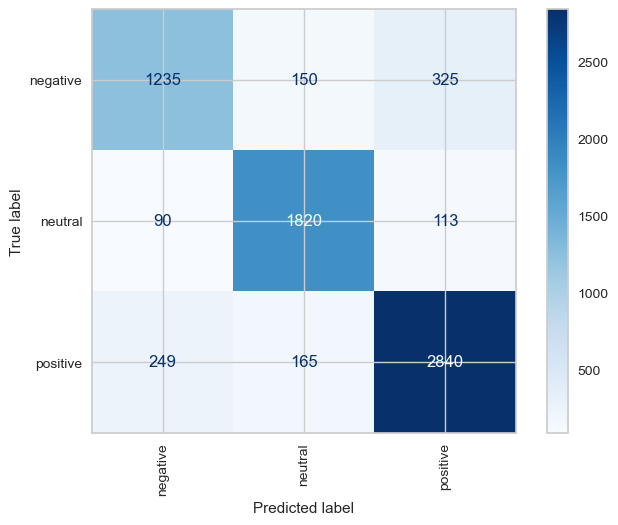

In [29]:
model_inplace(mlp_s,X_train,X_val,y_train,y_val)

score on train set: 0.9696102285196317
score on test set: 0.8356948618863603
              precision    recall  f1-score   support

    negative       0.95      0.98      0.96      5352
     neutral       0.96      0.99      0.98      6018
    positive       0.99      0.95      0.97      9591

    accuracy                           0.97     20961
   macro avg       0.97      0.97      0.97     20961
weighted avg       0.97      0.97      0.97     20961

              precision    recall  f1-score   support

    negative       0.77      0.72      0.75      1710
     neutral       0.81      0.96      0.87      2023
    positive       0.90      0.82      0.86      3254

    accuracy                           0.84      6987
   macro avg       0.82      0.83      0.83      6987
weighted avg       0.84      0.84      0.83      6987



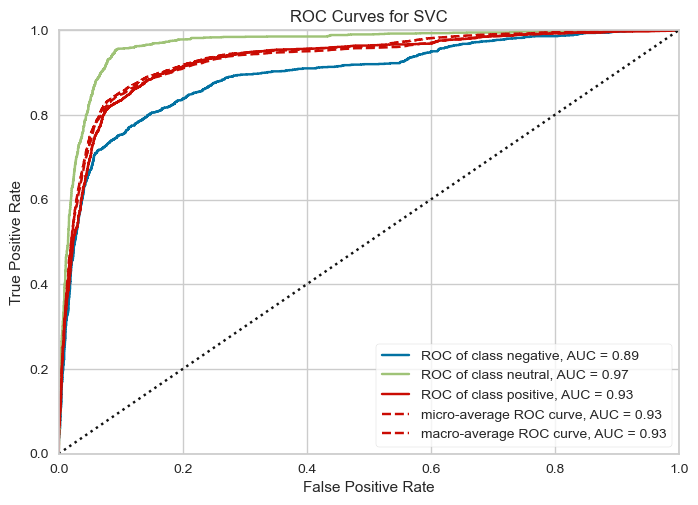

AxesSubplot(0.125,0.11;0.775x0.77)


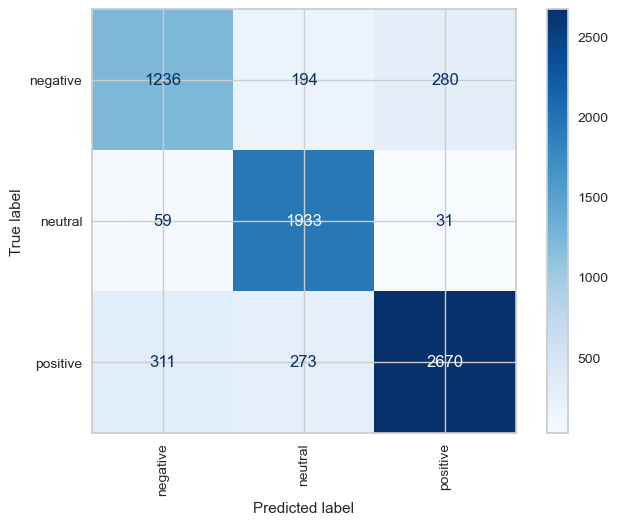

In [30]:
model_inplace(svc_s,X_train,X_val,y_train,y_val)

In [31]:
# Shap values of SVC models requires many hours to calculate, therefore was not calculated
#X_train_summary = shap.sample(X_train, 1000)
#explainer = shap.KernelExplainer(mlp_s.predict_proba, X_train_summary)
#shap_values = explainer.shap_values(X_train_summary)

score on train set: 0.8480511425981585
score on test set: 0.7921854873336196
              precision    recall  f1-score   support

    negative       0.94      0.66      0.78      5352
     neutral       0.76      0.95      0.85      6018
    positive       0.88      0.88      0.88      9591

    accuracy                           0.85     20961
   macro avg       0.86      0.83      0.84     20961
weighted avg       0.86      0.85      0.85     20961

              precision    recall  f1-score   support

    negative       0.84      0.54      0.66      1710
     neutral       0.74      0.93      0.82      2023
    positive       0.82      0.84      0.83      3254

    accuracy                           0.79      6987
   macro avg       0.80      0.77      0.77      6987
weighted avg       0.80      0.79      0.79      6987



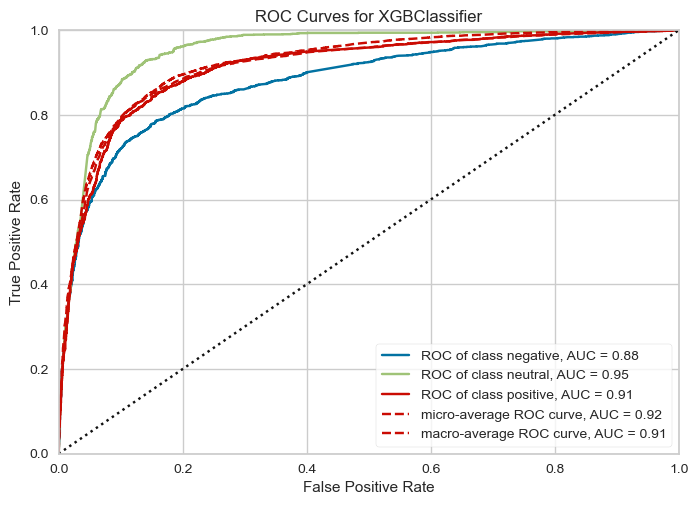

AxesSubplot(0.125,0.11;0.775x0.77)


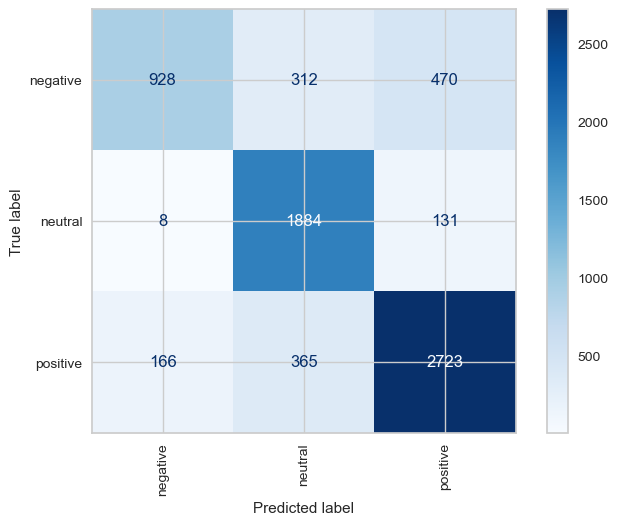

In [32]:
model_inplace(xgboost_s,X_train,X_val,y_train,y_val)

score on train set: 0.8708076904727828
score on test set: 0.838271074853299
              precision    recall  f1-score   support

    negative       0.90      0.71      0.80      5352
     neutral       0.81      0.99      0.89      6018
    positive       0.91      0.89      0.90      9591

    accuracy                           0.87     20961
   macro avg       0.87      0.86      0.86     20961
weighted avg       0.88      0.87      0.87     20961

              precision    recall  f1-score   support

    negative       0.84      0.63      0.72      1710
     neutral       0.79      0.98      0.88      2023
    positive       0.88      0.86      0.87      3254

    accuracy                           0.84      6987
   macro avg       0.84      0.82      0.82      6987
weighted avg       0.84      0.84      0.83      6987



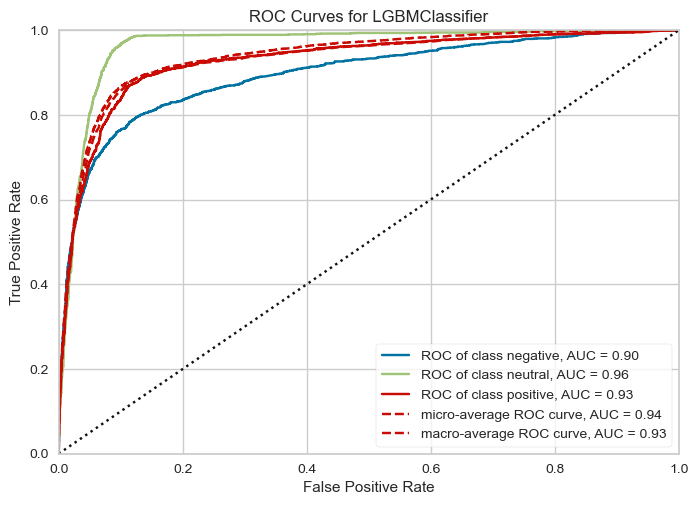

AxesSubplot(0.125,0.11;0.775x0.77)


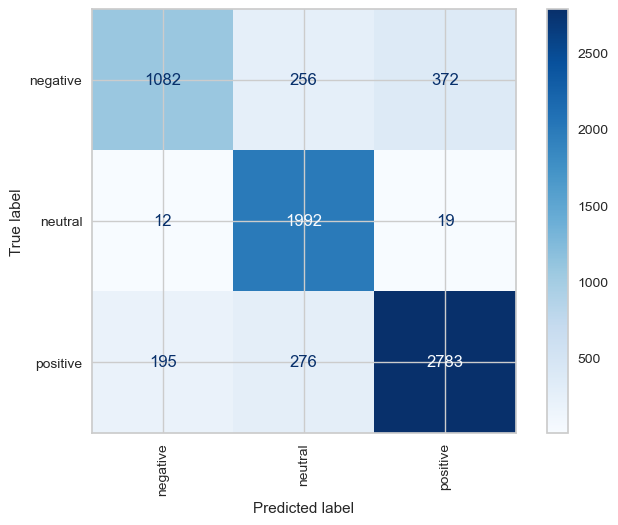

In [33]:
model_inplace(lgbmc_s,X_train,X_val,y_train,y_val)

In [34]:
#lgbmc.fit(X_train,y_train)

In [35]:
X_train_array = X_train.toarray()

In [36]:
#explainer = shap.Explainer(lgbmc_s)

In [37]:
shap_values = shap.Explainer(lgbmc_s).shap_values(X_train_array)

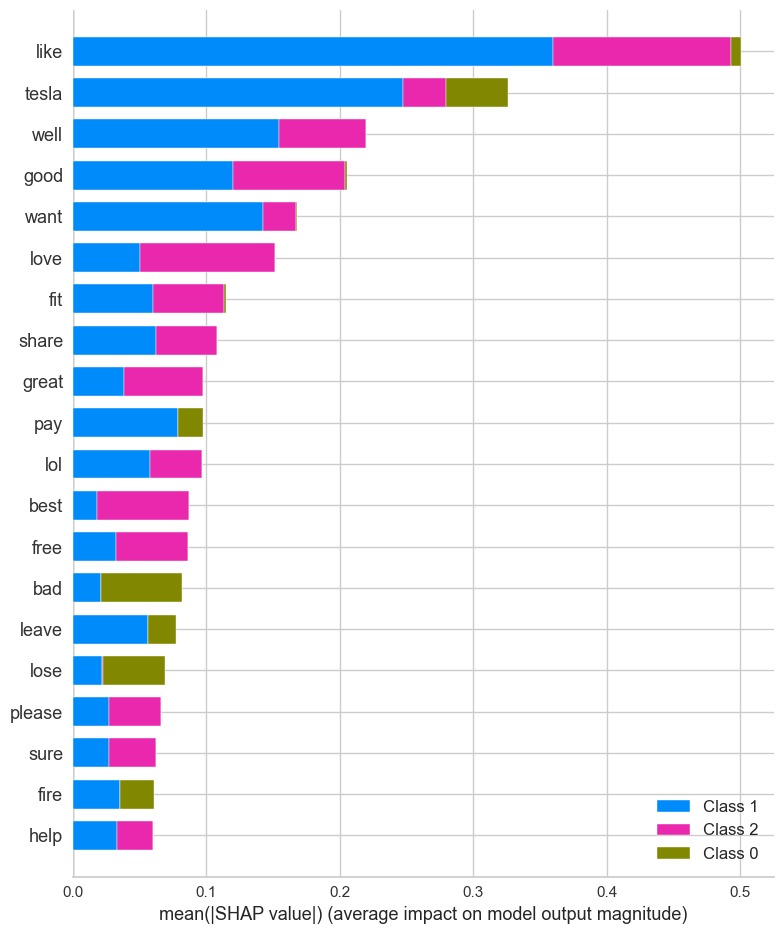

None


In [38]:
print(shap.summary_plot(shap_values, X_train_array, feature_names=vectorizer.get_feature_names()))

score on train set: 0.8850722770860169
score on test set: 0.8275368541577215
              precision    recall  f1-score   support

    negative       0.83      0.85      0.84      5352
     neutral       0.86      0.97      0.91      6018
    positive       0.94      0.85      0.89      9591

    accuracy                           0.89     20961
   macro avg       0.88      0.89      0.88     20961
weighted avg       0.89      0.89      0.88     20961

              precision    recall  f1-score   support

    negative       0.74      0.76      0.75      1710
     neutral       0.79      0.94      0.86      2023
    positive       0.91      0.79      0.85      3254

    accuracy                           0.83      6987
   macro avg       0.81      0.83      0.82      6987
weighted avg       0.84      0.83      0.83      6987



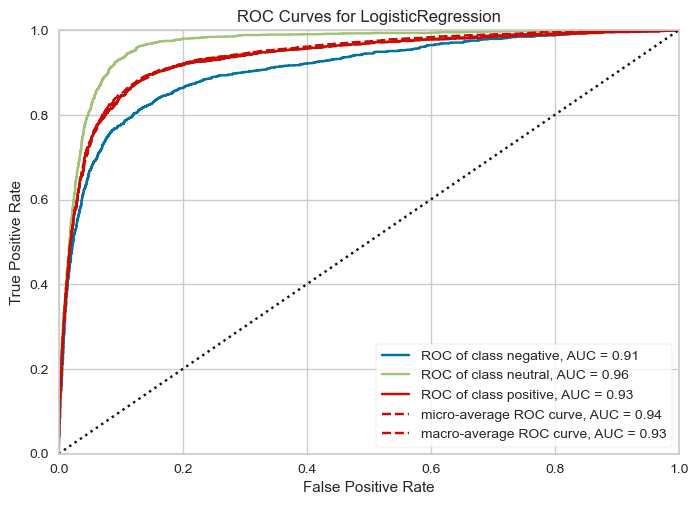

AxesSubplot(0.125,0.11;0.775x0.77)


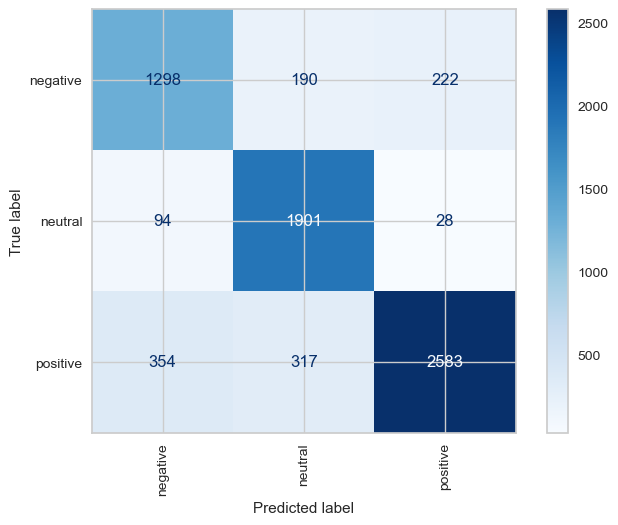

In [39]:
model_inplace(lr_s,X_train,X_val,y_train,y_val)

# Models with Hyperparameter tunning

score on train set: 0.9958017270168408
score on test set: 0.8571633032775153
              precision    recall  f1-score   support

    negative       1.00      0.99      1.00      5352
     neutral       0.99      1.00      0.99      6018
    positive       1.00      1.00      1.00      9591

    accuracy                           1.00     20961
   macro avg       1.00      1.00      1.00     20961
weighted avg       1.00      1.00      1.00     20961

              precision    recall  f1-score   support

    negative       0.79      0.74      0.77      1710
     neutral       0.86      0.94      0.89      2023
    positive       0.89      0.87      0.88      3254

    accuracy                           0.86      6987
   macro avg       0.85      0.85      0.85      6987
weighted avg       0.86      0.86      0.86      6987



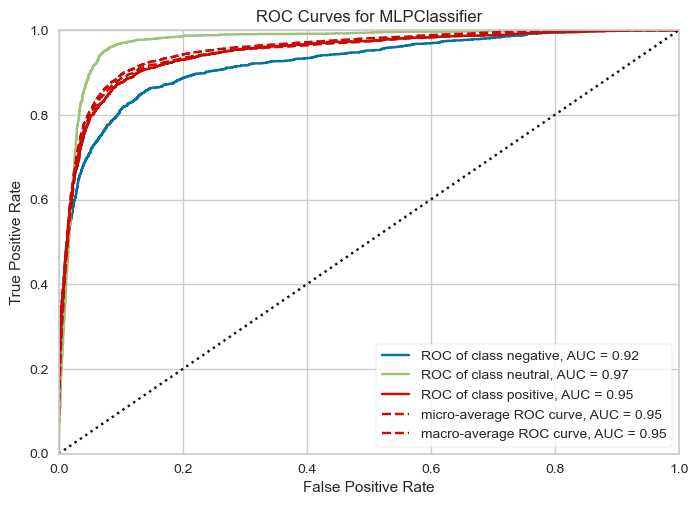

AxesSubplot(0.125,0.11;0.775x0.77)


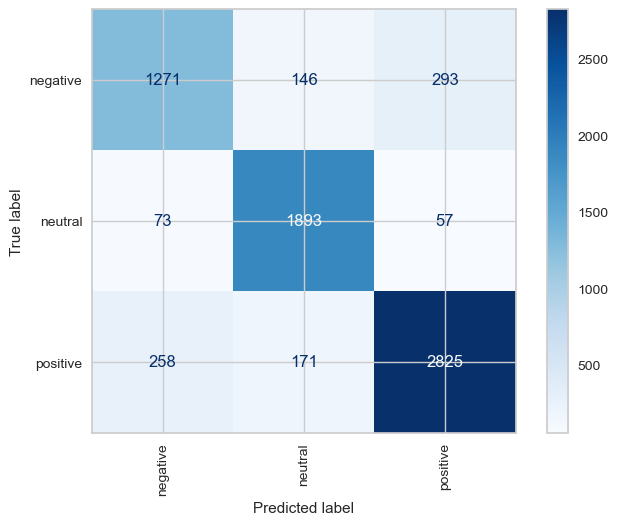

In [40]:
model_inplace(mlp,X_train,X_val,y_train,y_val)

score on train set: 0.9267687610323935
score on test set: 0.8621726062687849
              precision    recall  f1-score   support

    negative       0.92      0.84      0.88      5352
     neutral       0.92      0.99      0.95      6018
    positive       0.94      0.93      0.94      9591

    accuracy                           0.93     20961
   macro avg       0.92      0.92      0.92     20961
weighted avg       0.93      0.93      0.93     20961

              precision    recall  f1-score   support

    negative       0.82      0.71      0.76      1710
     neutral       0.85      0.97      0.91      2023
    positive       0.89      0.87      0.88      3254

    accuracy                           0.86      6987
   macro avg       0.85      0.85      0.85      6987
weighted avg       0.86      0.86      0.86      6987



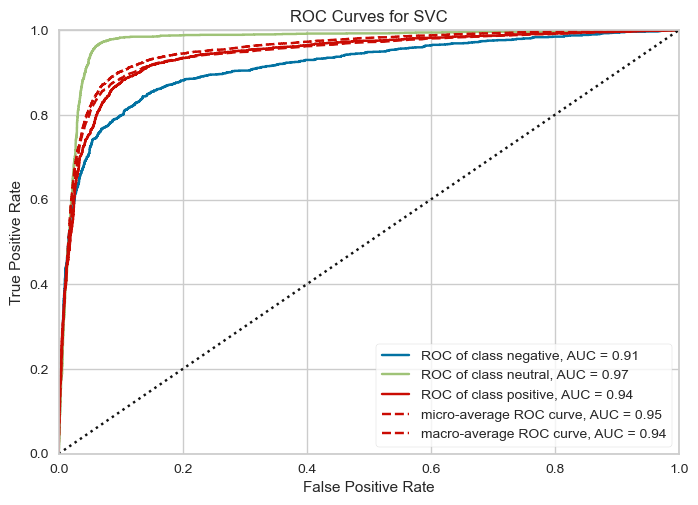

AxesSubplot(0.125,0.11;0.775x0.77)


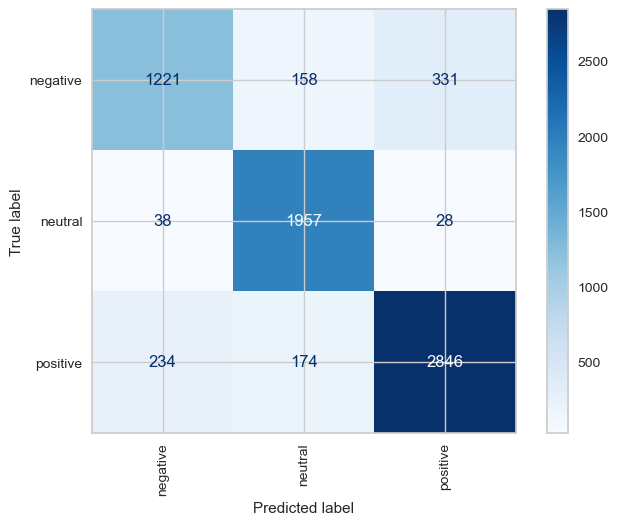

In [41]:
model_inplace(svc,X_train,X_val,y_train,y_val)

score on train set: 0.863031343924431
score on test set: 0.8003434950622584
              precision    recall  f1-score   support

    negative       0.95      0.69      0.80      5352
     neutral       0.79      0.96      0.87      6018
    positive       0.89      0.89      0.89      9591

    accuracy                           0.86     20961
   macro avg       0.87      0.85      0.85     20961
weighted avg       0.87      0.86      0.86     20961

              precision    recall  f1-score   support

    negative       0.84      0.55      0.67      1710
     neutral       0.75      0.94      0.83      2023
    positive       0.83      0.84      0.83      3254

    accuracy                           0.80      6987
   macro avg       0.81      0.78      0.78      6987
weighted avg       0.81      0.80      0.79      6987



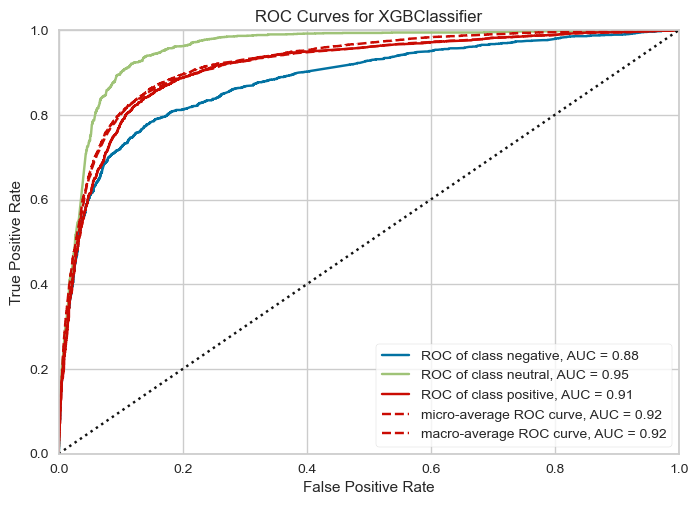

AxesSubplot(0.125,0.11;0.775x0.77)


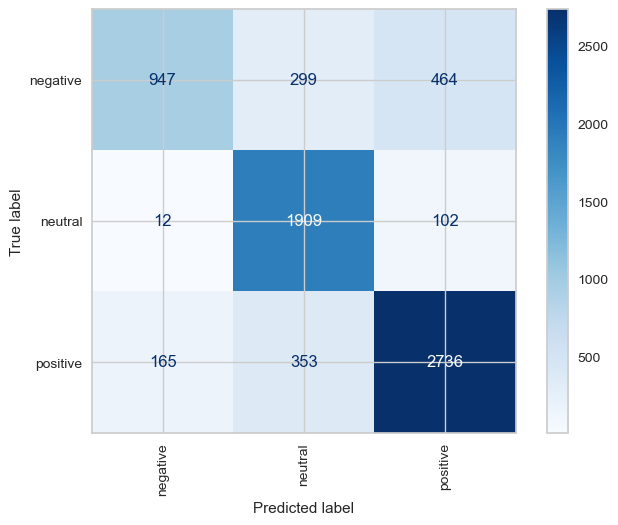

In [42]:
model_inplace(xgboost,X_train,X_val,y_train,y_val)

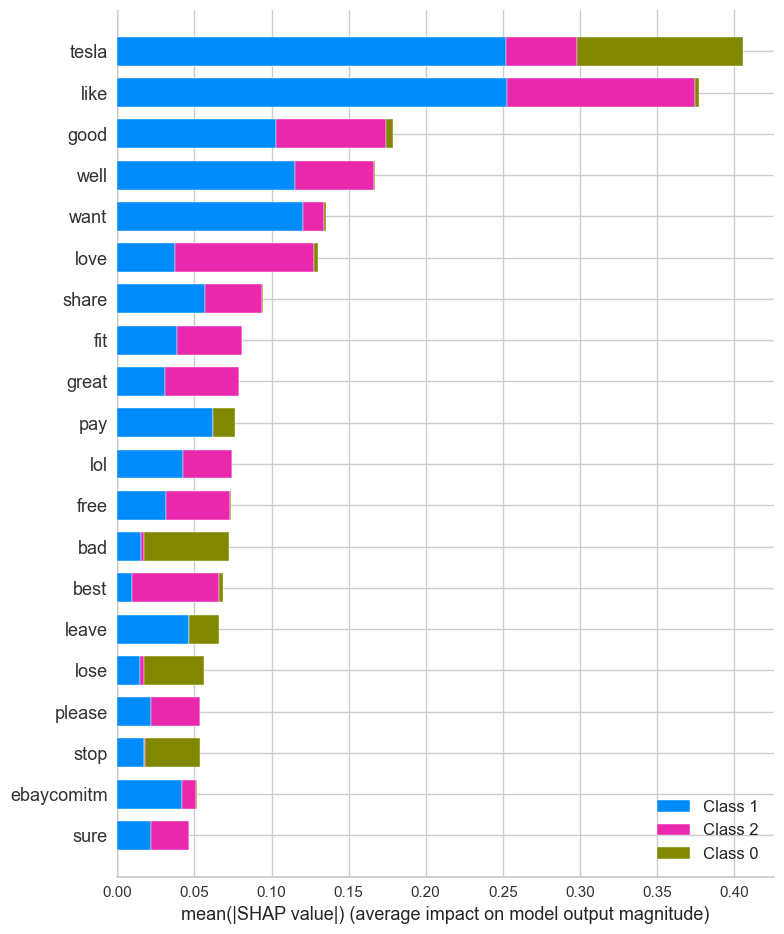

None


In [43]:
shap_values = shap.TreeExplainer(xgboost).shap_values(X_val)
X_val_array = X_val.toarray()
print(shap.summary_plot(shap_values, X_val_array, feature_names=vectorizer.get_feature_names()))

score on train set: 0.632174037498211
score on test set: 0.6212966938600257
              precision    recall  f1-score   support

    negative       0.52      0.53      0.52      5352
     neutral       0.55      0.87      0.68      6018
    positive       0.86      0.54      0.66      9591

    accuracy                           0.63     20961
   macro avg       0.64      0.65      0.62     20961
weighted avg       0.68      0.63      0.63     20961

              precision    recall  f1-score   support

    negative       0.50      0.51      0.50      1710
     neutral       0.55      0.88      0.68      2023
    positive       0.85      0.52      0.64      3254

    accuracy                           0.62      6987
   macro avg       0.63      0.64      0.61      6987
weighted avg       0.67      0.62      0.62      6987



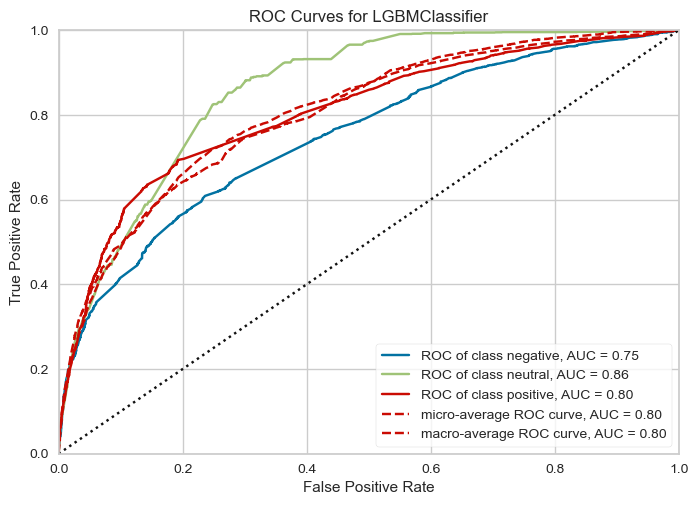

AxesSubplot(0.125,0.11;0.775x0.77)


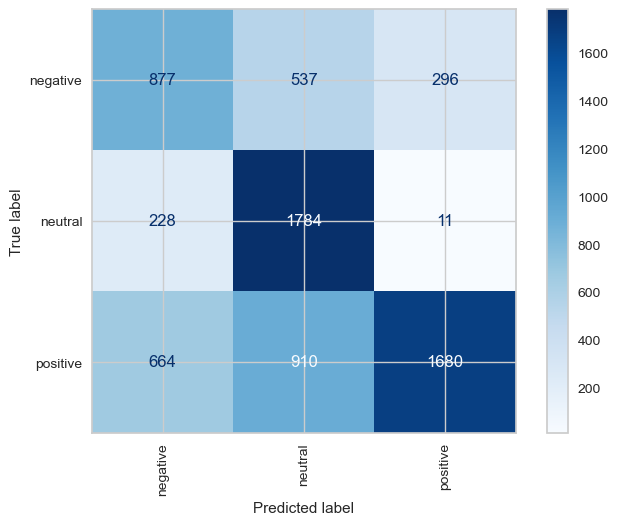

In [44]:
model_inplace(lgbmc,X_train,X_val,y_train,y_val)

score on train set: 0.9210915509756213
score on test set: 0.8587376556462001
              precision    recall  f1-score   support

    negative       0.91      0.83      0.87      5352
     neutral       0.92      0.98      0.95      6018
    positive       0.93      0.93      0.93      9591

    accuracy                           0.92     20961
   macro avg       0.92      0.92      0.92     20961
weighted avg       0.92      0.92      0.92     20961

              precision    recall  f1-score   support

    negative       0.82      0.72      0.77      1710
     neutral       0.85      0.94      0.90      2023
    positive       0.88      0.88      0.88      3254

    accuracy                           0.86      6987
   macro avg       0.85      0.85      0.85      6987
weighted avg       0.86      0.86      0.86      6987



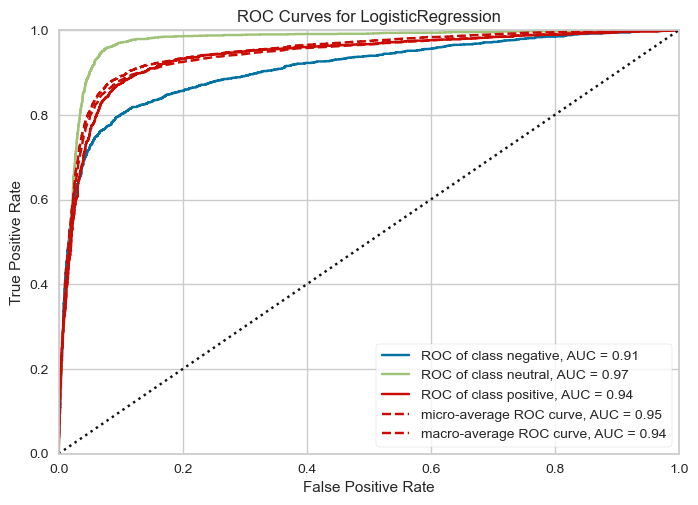

AxesSubplot(0.125,0.11;0.775x0.77)


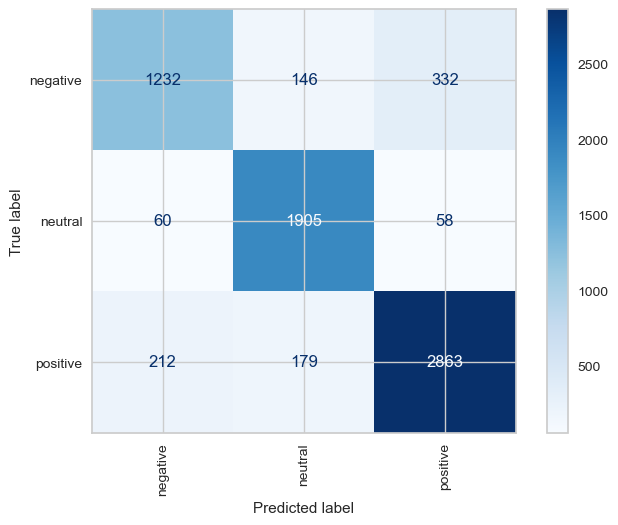

In [45]:
model_inplace(lr,X_train,X_val,y_train,y_val)

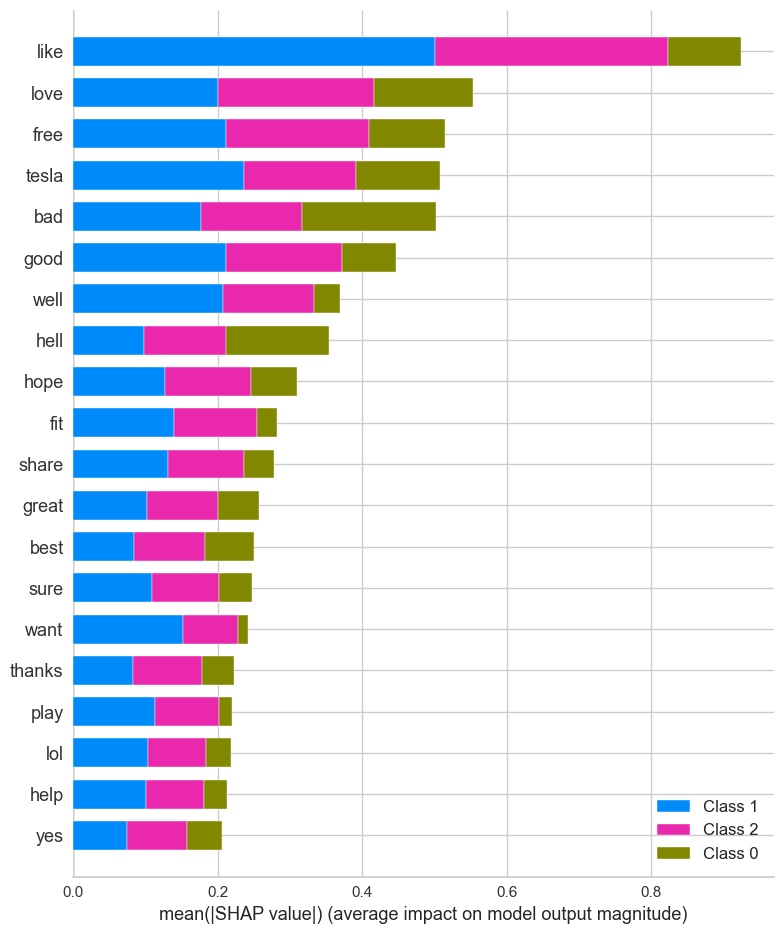

None


In [46]:
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_val)
X_val_array = X_val.toarray()
print(shap.summary_plot(shap_values, X_val_array, feature_names=vectorizer.get_feature_names()))

# SMOTE 

In [47]:
sm = SMOTE(k_neighbors = 3)

X_balance, y_balance = sm.fit_resample(X_train, y_train)

score on train set: 0.994091683175199
score on test set: 0.8522971232288535
              precision    recall  f1-score   support

    negative       0.99      1.00      0.99      9591
     neutral       0.99      0.99      0.99      9591
    positive       1.00      0.99      1.00      9591

    accuracy                           0.99     28773
   macro avg       0.99      0.99      0.99     28773
weighted avg       0.99      0.99      0.99     28773

              precision    recall  f1-score   support

    negative       0.78      0.73      0.76      1710
     neutral       0.87      0.91      0.89      2023
    positive       0.88      0.88      0.88      3254

    accuracy                           0.85      6987
   macro avg       0.84      0.84      0.84      6987
weighted avg       0.85      0.85      0.85      6987



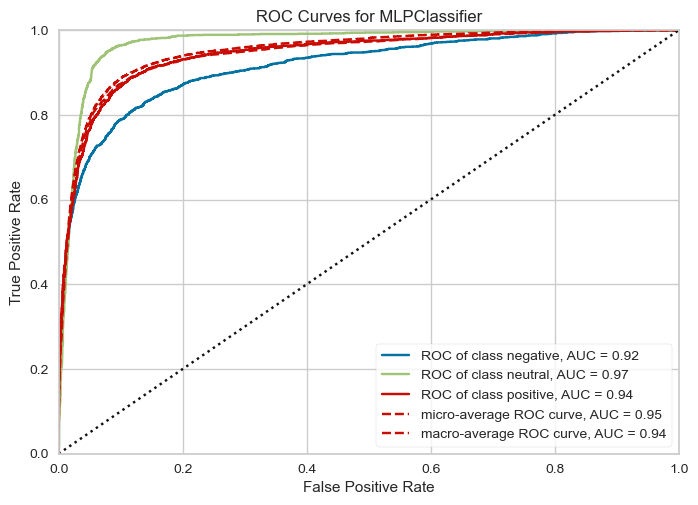

AxesSubplot(0.125,0.11;0.775x0.77)


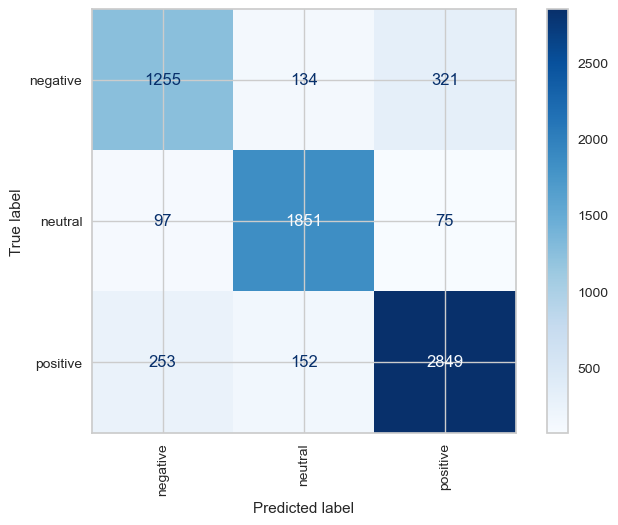

In [48]:
model_inplace(mlp,X_balance,X_val,y_balance,y_val)

score on train set: 0.9243040350328433
score on test set: 0.845427221983684
              precision    recall  f1-score   support

    negative       0.92      0.88      0.90      9591
     neutral       0.92      0.98      0.95      9591
    positive       0.93      0.91      0.92      9591

    accuracy                           0.92     28773
   macro avg       0.92      0.92      0.92     28773
weighted avg       0.92      0.92      0.92     28773

              precision    recall  f1-score   support

    negative       0.76      0.74      0.75      1710
     neutral       0.84      0.92      0.88      2023
    positive       0.89      0.85      0.87      3254

    accuracy                           0.85      6987
   macro avg       0.83      0.84      0.83      6987
weighted avg       0.85      0.85      0.84      6987



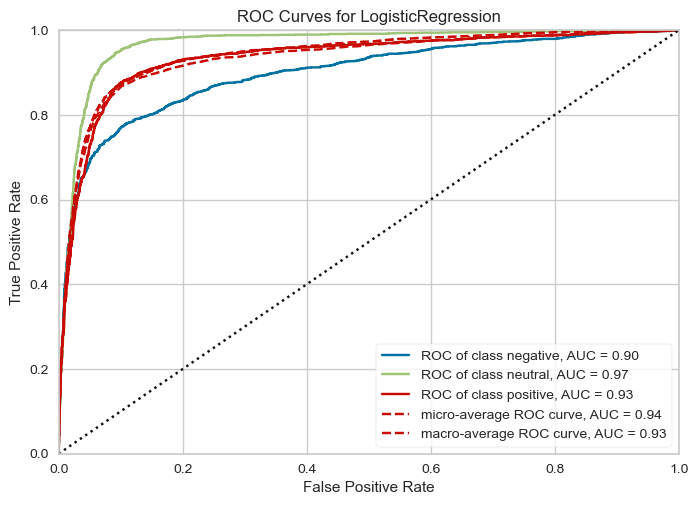

AxesSubplot(0.125,0.11;0.775x0.77)


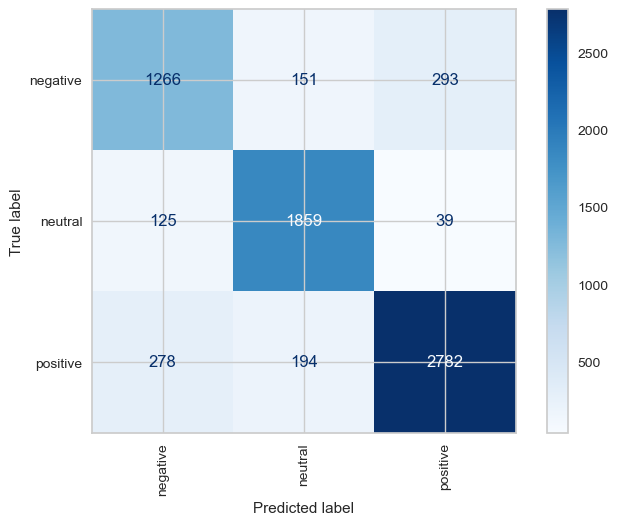

In [49]:
model_inplace(lr,X_balance,X_val,y_balance,y_val)

score on train set: 0.9202724776700378
score on test set: 0.8543008444253614
              precision    recall  f1-score   support

    negative       0.88      0.92      0.90      9591
     neutral       0.94      0.91      0.93      9591
    positive       0.94      0.93      0.94      9591

    accuracy                           0.92     28773
   macro avg       0.92      0.92      0.92     28773
weighted avg       0.92      0.92      0.92     28773

              precision    recall  f1-score   support

    negative       0.78      0.72      0.75      1710
     neutral       0.85      0.95      0.90      2023
    positive       0.89      0.86      0.88      3254

    accuracy                           0.85      6987
   macro avg       0.84      0.85      0.84      6987
weighted avg       0.85      0.85      0.85      6987



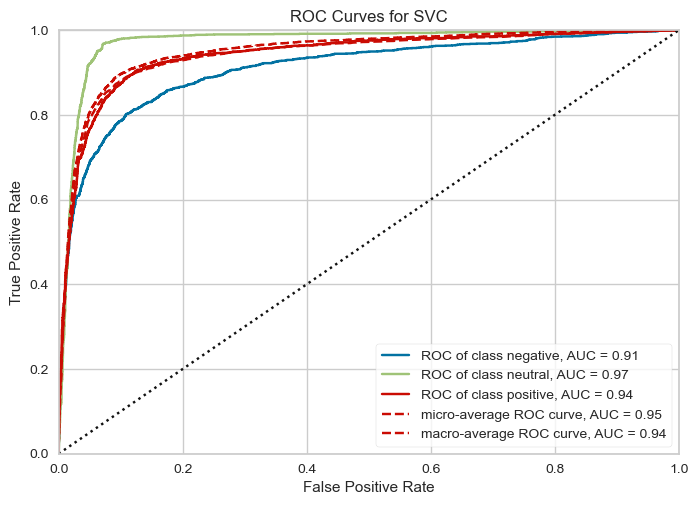

AxesSubplot(0.125,0.11;0.775x0.77)


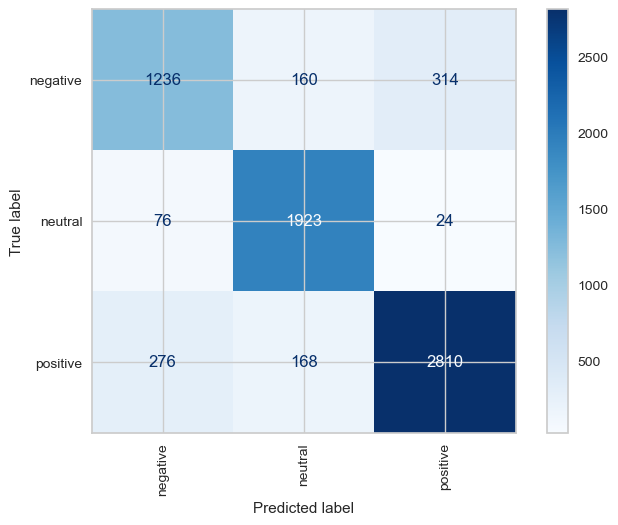

In [50]:
model_inplace(svc,X_balance,X_val,y_balance,y_val)

score on train set: 0.8702255586834879
score on test set: 0.7944754544153427
              precision    recall  f1-score   support

    negative       0.93      0.79      0.86      9591
     neutral       0.79      0.99      0.88      9591
    positive       0.92      0.83      0.87      9591

    accuracy                           0.87     28773
   macro avg       0.88      0.87      0.87     28773
weighted avg       0.88      0.87      0.87     28773

              precision    recall  f1-score   support

    negative       0.77      0.63      0.70      1710
     neutral       0.71      0.98      0.83      2023
    positive       0.89      0.76      0.82      3254

    accuracy                           0.79      6987
   macro avg       0.79      0.79      0.78      6987
weighted avg       0.81      0.79      0.79      6987



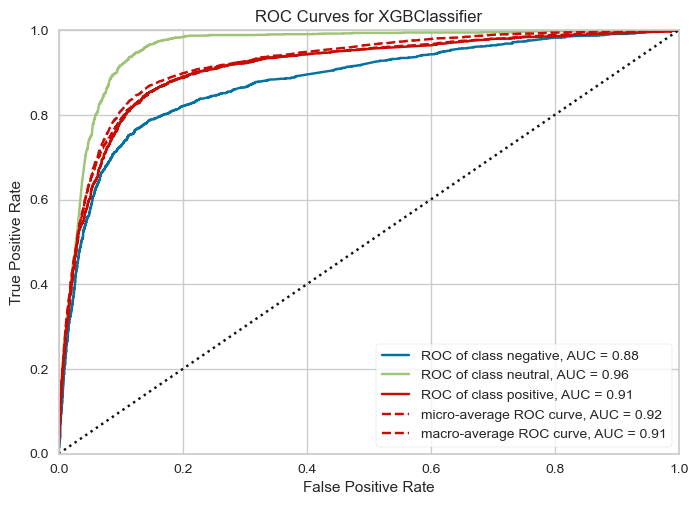

AxesSubplot(0.125,0.11;0.775x0.77)


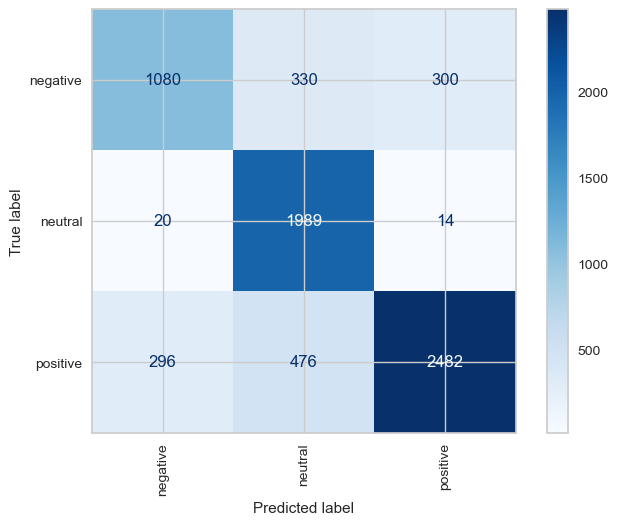

In [51]:
model_inplace(xgboost,X_balance,X_val,y_balance,y_val)

From all the models the best model is SVC with hyperparameters without SMOTE. 

## Bootstrapping the Validation Set Predictions 

In our model precision is more important than recall therefore I have tried to get Bootstrapped confidenc interval for Fbeta half score as it gives more importance to precision

In [80]:
def Confidence_interval(model):
    n_iterations = 200
    n_size = int(len(df) * 0.50)

    model = LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')
    model.fit(X_train,y_train)

    #run bootstrap
    stats = list()
    for i in range(n_iterations):
        X_bs,y_bs = resample(X_val,y_val, replace = True, n_samples = n_size)
        predictions = model.predict(X_bs)
        score = fbeta_score(y_bs, predictions, beta = 0.5, average = 'macro')
        stats.append(score)
        # plot scores
    pyplot.hist(stats)
    pyplot.show()
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, numpy.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, numpy.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


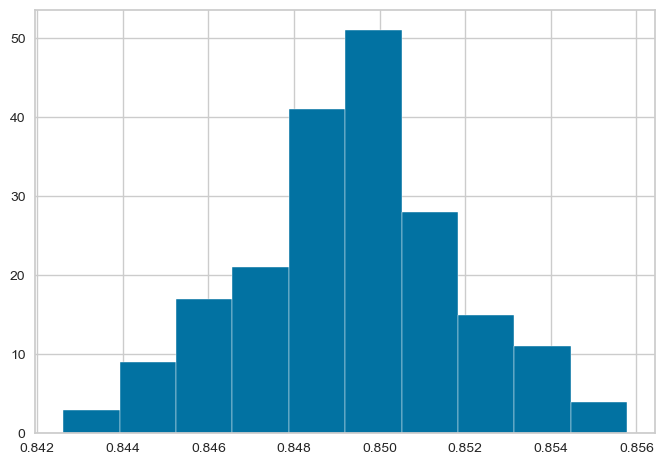

95.0 confidence interval 84.4% and 85.4%


In [81]:
Confidence_interval(lr)

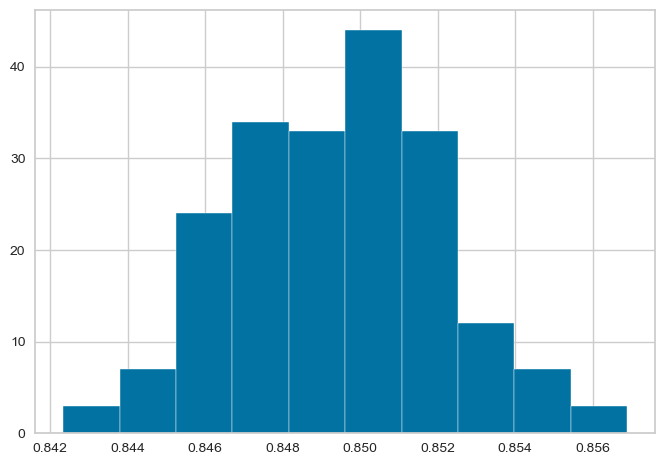

95.0 confidence interval 84.5% and 85.4%


In [73]:
Confidence_interval(svc)

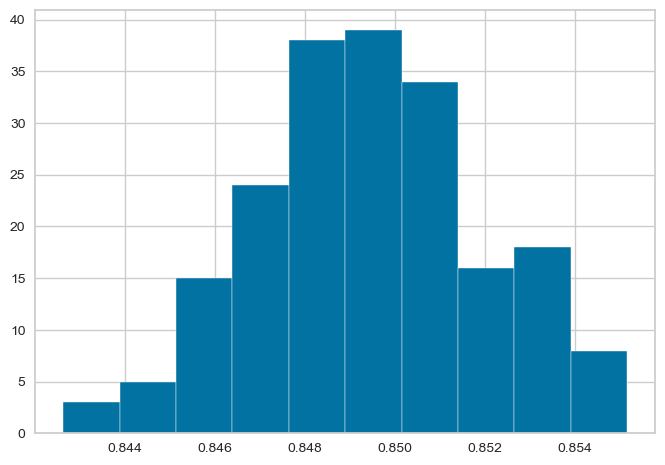

95.0 confidence interval 84.5% and 85.4%


In [74]:
Confidence_interval(mlp)

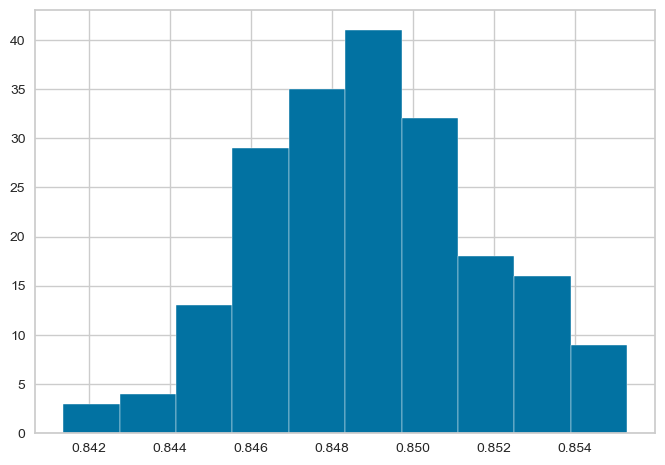

95.0 confidence interval 84.4% and 85.4%


In [75]:
Confidence_interval(lgbmc)

Bootstrapped confidence interval for all 4 models are very narrow and somehow same for all the models.
It shows that we are 95% confident that true Fbeta_half score for population lies b/w 84.4% and 85.4%. 